# Rastreamento de objetos e machine learning

Rastreamento de cores, objetos e aplicação de técnicas de machine learning pré-treinadas e desenvolvimento de algoritmos próprios.

Alguns recursos e códigos foram adaptados deste [repositório](https://github.com/udacity/CVND_Exercises/) do curso de Visão Computacional da Udacity.

## 1. Requerimentos

Utilize o comando ao lado para instalar pelo Anaconda terminal.

* OpenCV 3.4.3 (```conda install -c conda-forge opencv==3.4.3```)
* Pillow 7.0.0 (```conda install Pillow==7.0.0```)
* Pytorch 1.4.0 (```conda install -c pytorch pytorch==1.4.0```)
* Numpy 1.18.1 (```conda install numpy==1.15.2```)

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

#Exibição na mesma tela do Jupyter
%matplotlib inline

from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL

import datetime

import dlib

from os import listdir
from os.path import isfile, join

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

Verificando versão instalada do OpenCV

In [2]:
if cv2.__version__ == "3.4.3":
    print("Versão correta ("+ cv2.__version__  +").")
else:
    print("Versão incorreta ("+ cv2.__version__  +"). Instale a versão conforme instruções.")

Versão correta (3.4.3).


## 2. Machine Learning

### 2.1 Reconhecimento Facial

Gerando 100 exemplos de faces, utilizando a câmera.

In [3]:
# Extrator de faces
def face_extractor(imagem):
    classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')
    imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_RGB2GRAY)
    faces = classificador_face.detectMultiScale(imagem_gray, 1.2, 5)
    
    if faces is ():
        return None
    
    for (x,y,w,h) in faces:
        face_recortada = imagem[y:y+h, x:x+w]

    return face_recortada

#### Extração de características

Gerando imagems de exemplos para ser posteriormente treinado. Neste caso vamos adotar um tamanho de imagem para processamento de 200 x 200 (empírico).

Text(0.5, 1.0, 'Extração de faces')

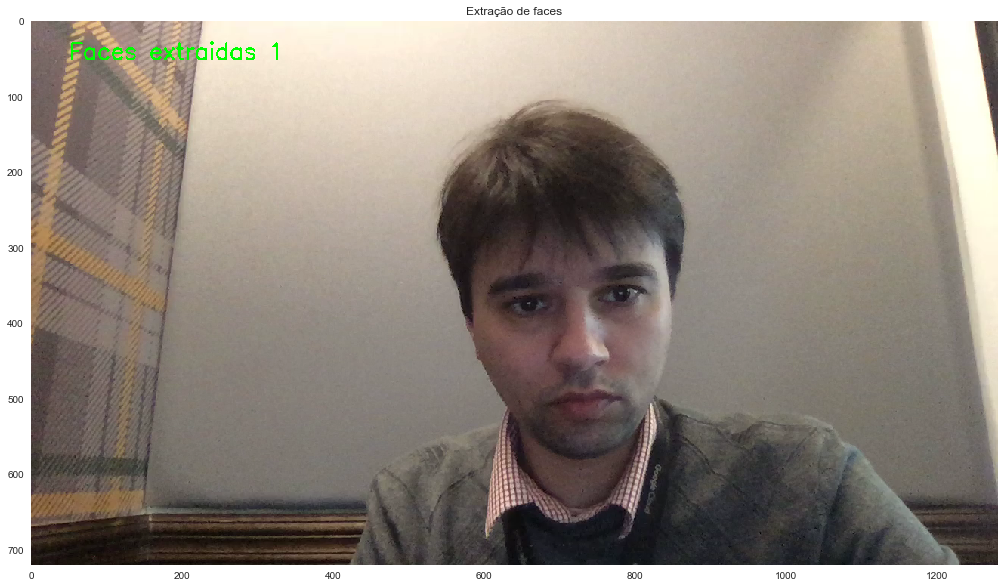

In [4]:
imagem = cv2.imread("imagens/camera_output_1.png")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Extração de faces")

Crie o diretório ```imagens/faces/michel``` ou o seu nome para salvar as amostras.

In [5]:
cam_capture = cv2.VideoCapture(0)

contador = 0

while contador <= 99:
    ret, frame = cam_capture.read()
    
    if ret:
        if face_extractor(frame) is not None:
            contador += 1

            face = cv2.resize(face_extractor(frame), (200, 200))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            imagem_path = 'imagens/faces/michel/' + str(contador) + '.jpg'
            cv2.imwrite(imagem_path, face)
            cv2.putText(frame, "Faces extraidas " +  str(contador), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        cv2.imshow("Tracos", frame)
        
    if cv2.waitKey(1) == 13:
        break
        
cam_capture.release()
cv2.destroyAllWindows()

#### Treinamento do modelo

Podemos testar os diversos tipos de classificadores, no entanto, o classificador LBPH tem o uso com melhor performance dentre o Eingenfaces e Fisherfaces.
Neste caso como temos apenas uma única pessoa, nosso dicionário de pessoas, ficou apenas com um único registro. Em casos de multiclasses, ou seja, mais de uma pessoa, cada uma delas deve ter um *id* associado, que é o valor de chave do dicionário.

In [9]:
# Carregando exemplos de arquivos previamente coletados
faces_path = 'imagens/faces/michel/'
lista_arquivos_imagens = [f for f in listdir(faces_path) if isfile(join(faces_path, f))]

dados_treinamento, labels = [], []

# Lendo as imagens e associando a um label
for i, arquivos in enumerate(lista_arquivos_imagens):
    imagem_path = faces_path + lista_arquivos_imagens[i]
    imagem = cv2.imread(imagem_path, cv2.IMREAD_GRAYSCALE)
    dados_treinamento.append(imagem)
    labels.append(0)

# Criando uma matriz da lista de labels
labels = np.asarray(labels, dtype=np.int32)

# Treinamento do modelo
model = cv2.face.LBPHFaceRecognizer_create()
#model = cv2.face.FisherFaceRecognizer_create()
#model = cv2.face.EigenFaceRecognizer_create()
model.train(dados_treinamento, labels)

print("Modelo treinado com sucesso.")

pessoas = {0: "Michel"}

Modelo treinado com sucesso.


#### Inferência do modelo

Função para identificar o rosto e segmentar da imagme principal. Também utilizaremos para desenhar um retângulo delimitador.
Note que estamos normalizando a imagem (mesma escala, 200 x 200) que as imagens de treinamento.

In [33]:
def face_detector(imagem):
    classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')
    imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_RGB2GRAY)
    faces = classificador_face.detectMultiScale(imagem_gray, 1.1, 5)
    
    if faces is ():
        return imagem, [], 0, 0
    
    for (x,y,w,h) in faces:
        cv2.rectangle(imagem,(x,y),(x+w,y+h),(0,255,255),2)
        roi = imagem[y:y+h, x:x+w]
        roi = cv2.resize(roi, (200, 200))
    
    return imagem, roi, x, y

Obtendo as imagems por meio da câmera e fazendo a inferência on-line.

Text(0.5,1,'Inferência do modelo')

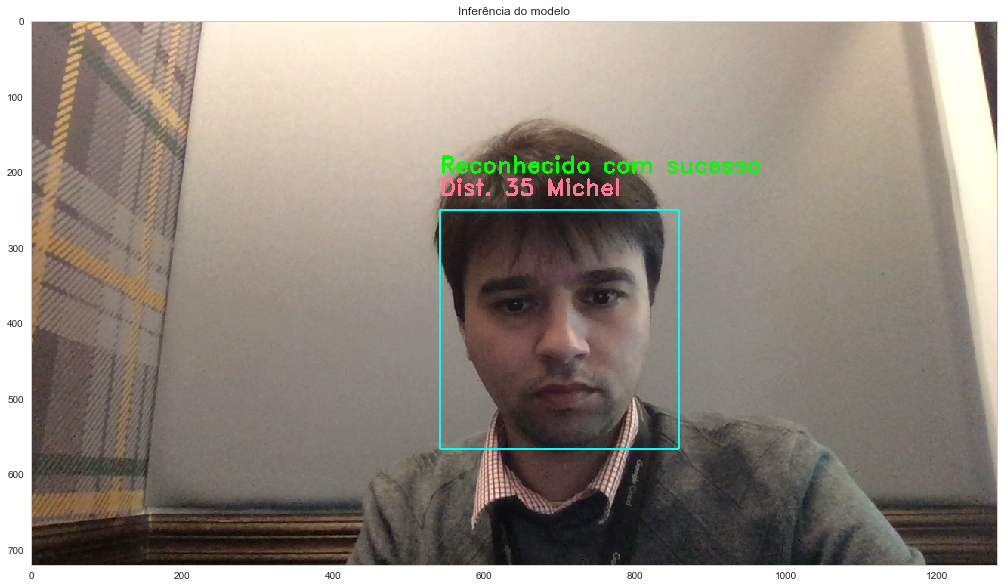

In [6]:
imagem = cv2.imread("imagens/camera_output_2.png")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(imagem)
plt.title("Inferência do modelo")

In [ ]:
cam_capture = cv2.VideoCapture(0)

while True:
    ret, frame = cam_capture.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        imagem, face, x, y = face_detector(frame)

        if face is not ():
            face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
            predicao = model.predict(face)

            if x > 0:
                notificacao = "Dist. " + str(int(predicao[1])) + ' ' + pessoas[predicao[0]] 
                cv2.putText(frame, notificacao, (x, y-20), cv2.FONT_HERSHEY_DUPLEX, 1, (255,120,150), 2)

            if int(predicao[1]) < 40:
                cv2.putText(frame, "Reconhecido com sucesso", (x, y-50), cv2.FONT_HERSHEY_DUPLEX, 1, (0,255,0), 2)
            else:
                cv2.putText(frame, "Nao reconhecido", (250, 450), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)
                
        cv2.imshow("Face", frame)
    if cv2.waitKey(1) == 13:
        break
        
cam_capture.release()
cv2.destroyAllWindows()

### 2.2 Classificador de Objetos
#### Yolo

É necessário baixar os pesos (modelo de deep-learning) neste link https://pjreddie.com/media/files/yolov3.weights e copiar para  pasta weights.

In [29]:
from utils import *
from darknet import Darknet

# Configurações na rede neural YOLOv3
cfg_file = 'cfg/yolov3.cfg'
m = Darknet(cfg_file)

# Pesos pré-treinados
weight_file = 'pesos/yolov3.weights'
m.load_weights(weight_file)

# Rótulos de classes
namesfile = 'data/coco.names'
class_names = load_class_names(namesfile)

Verificar versão do Numpy para compatibilidade com as bibliotecas da Darknet.

In [30]:
if np.version.version == "1.18.1":
    print("Versão correta ("+ np.version.version  +").")
else:
    print("Versão incorreta ("+ np.version.version  +"). Instale a versão conforme instruções.")

Versão correta (1.18.1).


In [31]:
# Topologia da rede neural da YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256
   13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128
   14 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256
   15 shortcut 12
   16 conv    128  1 x 1

In [32]:
print("Tamanho da imagem de entrada da rede: " + str(m.width) + "x" + str(m.height))

Tamanho da imagem de entrada da rede: 608x608


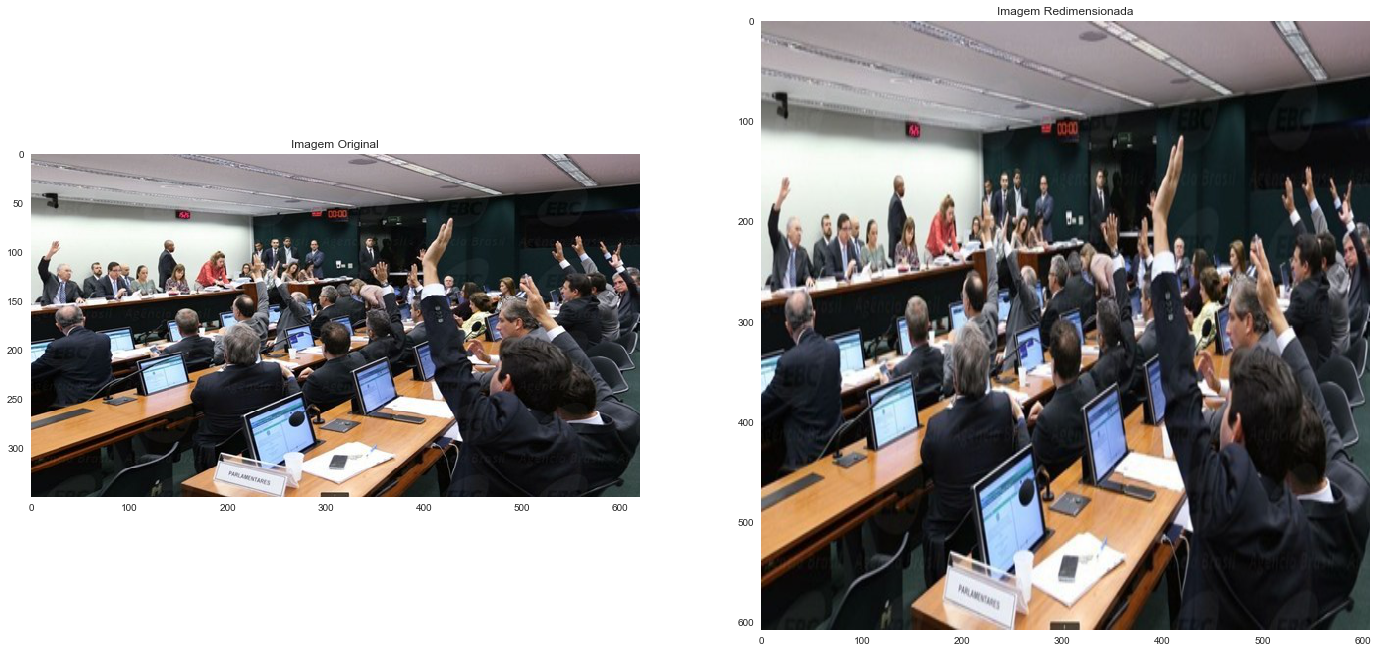

In [33]:
# Tamanho da figura
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Carregando imagem para classificar
img_path = "imagens/camara.jpg"
img = cv2.imread(img_path)

# Convertendo para o espaço de cores RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionando imagem para ser compatível com a primeira camada da rede neural  
resized_image = cv2.resize(original_image, (m.width, m.height))

# Exibição das imagens
plt.subplot(121)
plt.title("Imagem Original")
plt.imshow(original_image)
plt.subplot(122)
plt.title("Imagem Redimensionada")
plt.imshow(resized_image)
plt.show()

In [34]:
# Patamar de NMS (Non-Maximum Supression)
# Ajuste de sensibilidade de imagens com baixa luminosidade
nms_thresh = 0.6

# Patamar do IOU (Intersect of Union), indicador se o retângulo 
# de identificação de imagem foi adequadamente desenhado
iou_thresh = 0.4



It took 13.375 seconds to detect the objects in the image.

Number of Objects Detected: 36 

Objects Found and Confidence Level:

1. laptop: 1.000000
2. tvmonitor: 0.951783
3. person: 1.000000
4. person: 1.000000
5. person: 1.000000
6. person: 1.000000
7. person: 1.000000
8. person: 0.999998
9. person: 1.000000
10. person: 1.000000
11. laptop: 0.592837
12. person: 0.999998
13. person: 1.000000
14. laptop: 0.827528
15. person: 1.000000
16. person: 0.999999
17. laptop: 0.958368
18. chair: 0.962545
19. person: 0.999998
20. cup: 0.999995
21. cell phone: 0.999945
22. person: 1.000000
23. person: 0.999988
24. person: 0.999972
25. person: 0.999995
26. person: 0.999972
27. person: 1.000000
28. person: 1.000000
29. person: 1.000000
30. person: 0.999998
31. laptop: 0.992368
32. laptop: 0.996668
33. cell phone: 0.996766
34. person: 0.999999
35. tie: 1.000000
36. cell phone: 0.992012


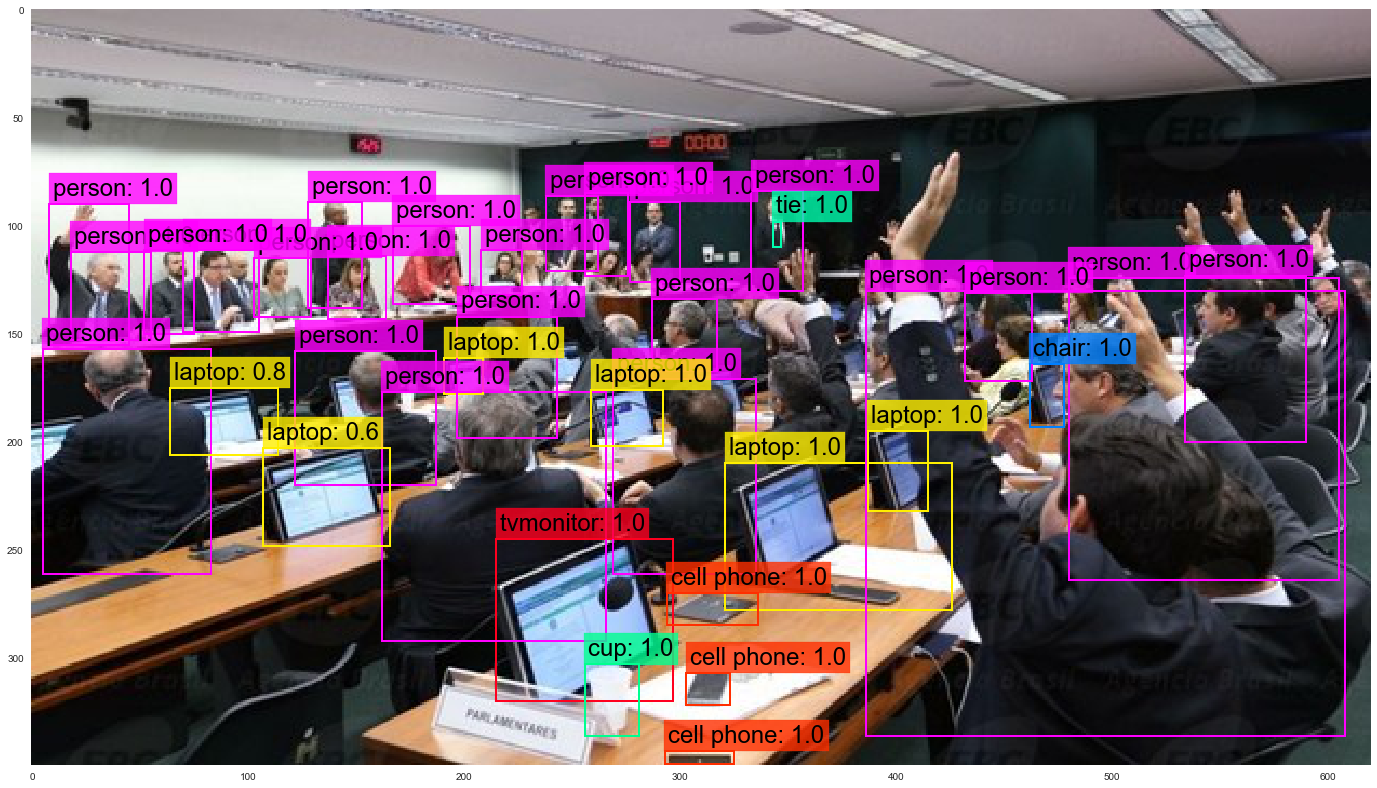

In [35]:
# Definindo tamnaho do gráfico
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Carregar imagem para classificação
img = cv2.imread(img_path)

# Conversão para o espaço RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionamento para adatapção da primeira camada da rede neural 
resized_image = cv2.resize(original_image, (m.width, m.height))

# Deteteção de objetos na imagem
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Objetos encontrados e nível de confiança
print_objects(boxes, class_names)

# Desenho no gráfico com os regângulos e rótulos
plot_boxes(original_image, boxes, class_names, plot_labels = True)

In [36]:
list_objects(boxes, class_names)

['laptop',
 'tvmonitor',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'laptop',
 'person',
 'person',
 'laptop',
 'person',
 'person',
 'laptop',
 'chair',
 'person',
 'cup',
 'cell phone',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'laptop',
 'laptop',
 'cell phone',
 'person',
 'tie',
 'cell phone']